# Predicting Bounding Boxes

## Imports

In [1]:
import os, re, time, json, zipfile
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import cv2

2024-07-23 15:21:59.123449: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 15:21:59.123560: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 15:21:59.239497: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Download and Extract the Dataset

In [2]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-3-public/datasets/caltech_birds2010_011.zip

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-07-23 15:22:12--  https://storage.googleapis.com/tensorflow-3-public/datasets/caltech_birds2010_011.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.76.123, 142.251.221.91, 172.217.167.123, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.76.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 688150437 (656M) [application/zip]
Saving to: 'caltech_birds2010_011.zip'

caltech_birds2010_0 100%[===================>] 656.27M  22.0MB/s    in 35s     

2024-07-23 15:22:48 (18.6 MB/s) - 'caltech_birds2010_011.zip' saved [688150437/688150437]



In [3]:
# Specify the data directory
data_dir = "./data"

# Create the data directory
try:
  os.mkdir(data_dir)
except FileExistsError:
  print(f'{data_dir} already exists')

# Extract the dataset into the data directory
with zipfile.ZipFile('./caltech_birds2010_011.zip') as zipref:
  zipref.extractall(data_dir)

## Visualization Utilities

### Bounding Boxes Utilities

In [4]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color=(255, 0, 0), thickness=5):
    """
    Adds a bounding box to an image.
    Bounding box coordinates can be specified in either absolute (pixel) or
    normalized coordinates by setting the use_normalized_coordinates argument.

    Args:
      image: a PIL.Image object.
      ymin: ymin of bounding box.
      xmin: xmin of bounding box.
      ymax: ymax of bounding box.
      xmax: xmax of bounding box.
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
    """

    image_width = image.shape[1]
    image_height = image.shape[0]
    cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)


def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image.

    Args:
      image: a PIL.Image object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.

    Raises:
      ValueError: if boxes is not a [N, 4] array
    """

    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be of size [N, 4]')
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                                 boxes[i, 2], color[i], thickness)


def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image (numpy array).

    Args:
      image: a numpy array object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
      display_str_list_list: a list of strings for each bounding box.

    Raises:
      ValueError: if boxes is not a [N, 4] array
    """

    draw_bounding_boxes_on_image(image, boxes, color, thickness)

    return image

### Data and Predictions Utilities

In [5]:
# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")


# utility to display a row of digits with their predictions
def display_digits_with_boxes(images, pred_bboxes, bboxes, iou, title, bboxes_normalized=False):

    n = len(images)

    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])

    for i in range(n):
      ax = fig.add_subplot(1, 10, i+1)
      bboxes_to_plot = []
      if (len(pred_bboxes) > i):
        bbox = pred_bboxes[i]
        bbox = [bbox[0] * images[i].shape[1], bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0]]
        bboxes_to_plot.append(bbox)

      if (len(bboxes) > i):
        bbox = bboxes[i]
        if bboxes_normalized == True:
          bbox = [bbox[0] * images[i].shape[1],bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0] ]
        bboxes_to_plot.append(bbox)

      img_to_draw = draw_bounding_boxes_on_image_array(image=images[i], boxes=np.asarray(bboxes_to_plot), color=[(255,0,0), (0, 255, 0)])
      plt.xticks([])
      plt.yticks([])

      plt.imshow(img_to_draw)

      if len(iou) > i :
        color = "black"
        if (iou[i][0] < iou_threshold):
          color = "red"
        ax.text(0.2, -0.3, "iou: %s" %(iou[i][0]), color=color, transform=ax.transAxes)


# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

## Preprocess and Load the Dataset

### Preprocessing Utilities

In [6]:
def read_image_tfds(image, bbox):
    image = tf.cast(image, tf.float32)
    shape = tf.shape(image)

    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)

    image = tf.image.resize(image, (224, 224,))

    image = image/127.5
    image -= 1

    bbox_list = [bbox[0] / factor_x ,
                 bbox[1] / factor_y,
                 bbox[2] / factor_x ,
                 bbox[3] / factor_y]

    return image, bbox_list

In [7]:
def read_image_with_shape(image, bbox):
    original_image = image

    image, bbox_list = read_image_tfds(image, bbox)

    return original_image, image, bbox_list

In [8]:
def read_image_tfds_with_original_bbox(data):
    image = data["image"]
    bbox = data["bbox"]

    shape = tf.shape(image)
    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)

    bbox_list = [bbox[1] * factor_x ,
                 bbox[0] * factor_y,
                 bbox[3] * factor_x,
                 bbox[2] * factor_y]
    return image, bbox_list

In [9]:
def dataset_to_numpy_util(dataset, batch_size=0, N=0):

    # eager execution: loop through datasets normally
    take_dataset = dataset.shuffle(1024)

    if batch_size > 0:
        take_dataset = take_dataset.batch(batch_size)

    if N > 0:
        take_dataset = take_dataset.take(N)

    if tf.executing_eagerly():
        ds_images, ds_bboxes = [], []
        for images, bboxes in take_dataset:
            ds_images.append(images.numpy())
            ds_bboxes.append(bboxes.numpy())

    return (np.array(ds_images, dtype='object'), np.array(ds_bboxes, dtype='object'))

In [10]:
def dataset_to_numpy_with_original_bboxes_util(dataset, batch_size=0, N=0):

    normalized_dataset = dataset.map(read_image_with_shape)
    if batch_size > 0:
        normalized_dataset = normalized_dataset.batch(batch_size)

    if N > 0:
        normalized_dataset = normalized_dataset.take(N)

    if tf.executing_eagerly():
        ds_original_images, ds_images, ds_bboxes = [], [], []

    for original_images, images, bboxes in normalized_dataset:
        ds_images.append(images.numpy())
        ds_bboxes.append(bboxes.numpy())
        ds_original_images.append(original_images.numpy())

    return np.array(ds_original_images, dtype='object'), np.array(ds_images, dtype='object'), np.array(ds_bboxes, dtype='object')

### Visualize the images and their bounding box labels

tfds.core.DatasetInfo(
    name='caltech_birds2010',
    full_name='caltech_birds2010/0.1.1',
    description="""
    Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
    of 200 bird species (mostly North American). The total number of 
    categories of birds is 200 and there are 6033 images in the 2010 
    dataset and 11,788 images in the 2011 dataset.
    Annotations include bounding boxes, segmentation labels.
    """,
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    data_dir='./data/caltech_birds2010/0.1.1',
    file_format=tfrecord,
    download_size=659.14 MiB,
    dataset_size=659.64 MiB,
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=200),
        'label_name': Text(shape=(), dtype=string),
        'segmentation_mask': Imag

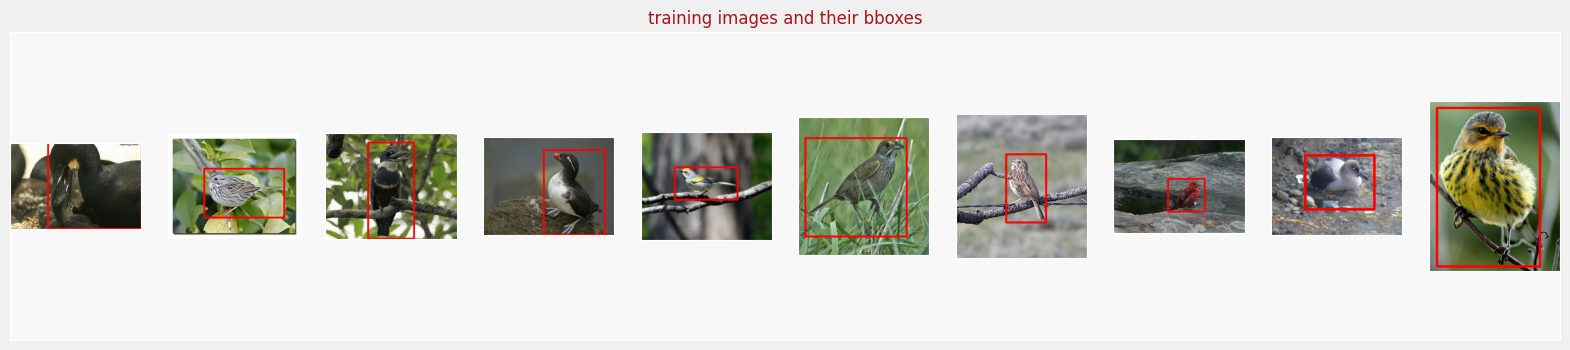

In [11]:
def get_visualization_training_dataset():
    dataset, info = tfds.load("caltech_birds2010", split="train", with_info=True, data_dir=data_dir, download=False)
    print(info)
    visualization_training_dataset = dataset.map(read_image_tfds_with_original_bbox,
                                                 num_parallel_calls=16)
    return visualization_training_dataset


visualization_training_dataset = get_visualization_training_dataset()


(visualization_training_images, visualization_training_bboxes) = dataset_to_numpy_util(visualization_training_dataset, N=10)
display_digits_with_boxes(np.array(visualization_training_images), np.array([]), np.array(visualization_training_bboxes), np.array([]), "training images and their bboxes")

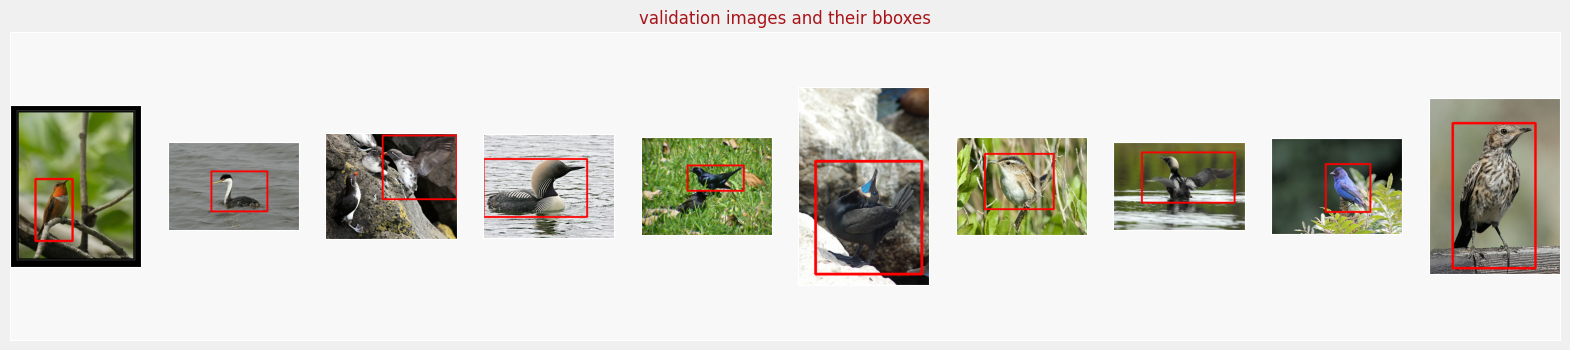

In [12]:
def get_visualization_validation_dataset():
    dataset = tfds.load("caltech_birds2010", split="test", data_dir=data_dir, download=False)
    visualization_validation_dataset = dataset.map(read_image_tfds_with_original_bbox, num_parallel_calls=16)
    return visualization_validation_dataset


visualization_validation_dataset = get_visualization_validation_dataset()

(visualization_validation_images, visualization_validation_bboxes) = dataset_to_numpy_util(visualization_validation_dataset, N=10)
display_digits_with_boxes(np.array(visualization_validation_images), np.array([]), np.array(visualization_validation_bboxes), np.array([]), "validation images and their bboxes")

### Load and prepare the datasets for the model

In [13]:
BATCH_SIZE = 64

def get_training_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(-1)
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    return dataset

training_dataset = get_training_dataset(visualization_training_dataset)
validation_dataset = get_validation_dataset(visualization_validation_dataset)

## Define the Network

### Exercise 1

In [14]:
def feature_extractor(inputs):
    ### YOUR CODE HERE ###

    # Create a mobilenet version 2 model object
    mobilenet_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')


    # pass the inputs into this modle object to get a feature extractor for these inputs
    feature_extractor = mobilenet_model(inputs)


    ### END CODE HERE ###

    # return the feature_extractor
    return feature_extractor

### Exercise 2

In [15]:
def dense_layers(features):
    ### YOUR CODE HERE ###

    # global average pooling 2d layer
    x = tf.keras.layers.GlobalAveragePooling2D()(features)

    # flatten layer
    x = tf.keras.layers.Flatten()(x)

    # 1024 Dense layer, with relu
    x = tf.keras.layers.Dense(1024, activation='relu')(x)

    # 512 Dense layer, with relu
    x = tf.keras.layers.Dense(512, activation='relu')(x)

    ### END CODE HERE ###

    return x

### Exercise 3

In [16]:
def bounding_box_regression(x):
    ### YOUR CODE HERE ###

    # Dense layer named `bounding_box`
    bounding_box_regression_output = tf.keras.layers.Dense(4, name = 'bounding_box')(x)

    ### END CODE HERE ###


    return bounding_box_regression_output

### Exercise 4

In [17]:
def final_model(inputs):
    ### YOUR CODE HERE ###

    # features
    feature_cnn = feature_extractor(inputs)

    # dense layers
    last_dense_layer = dense_layers(feature_cnn)

    # bounding box
    bounding_box_output = bounding_box_regression(last_dense_layer)

    # define the TensorFlow Keras model using the inputs and outputs to your model
    model = tf.keras.Model(inputs = inputs, outputs = bounding_box_output)

    ### END CODE HERE ###


    return model

### Exercise 5

In [18]:
def define_and_compile_model():

    ### YOUR CODE HERE ###

    # define the input layer
    inputs = tf.keras.layers.Input(shape=(224, 224, 3))

    # create the model
    model = final_model(inputs)

    # compile your model
    model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), 
                 loss = 'mse', 
                 metrics=['acc'])

    ### END CODE HERE ###


    return model

In [19]:
# define your model
model = define_and_compile_model()
# print model layers
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bounding_box (Dense)            │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,096,580 (15.63 MB)

 Trainable params: 4,062,468 (15.50 MB)

 Non-trainable params: 34,112 (133.25 KB)

## Train the Model

### Prepare to Train the Model

### Exercise 6

In [20]:
import math
# You'll train 50 epochs
EPOCHS = 50

### START CODE HERE ###

# Choose a batch size
BATCH_SIZE = 20

# Get the length of the training set
length_of_training_dataset = len(visualization_training_dataset)

# Get the length of the validation set
length_of_validation_dataset = len(visualization_validation_dataset)

# Get the steps per epoch (may be a few lines of code)
steps_per_epoch = math.ceil(length_of_training_dataset / BATCH_SIZE)

# get the validation steps (per epoch) (may be a few lines of code)
validation_steps = length_of_validation_dataset//BATCH_SIZE
if length_of_validation_dataset % BATCH_SIZE > 0:
    validation_steps += 1

### END CODE HERE

In [21]:
print(len(visualization_validation_dataset))

3033


## Fit the model to the data

### Exercise 7

In [22]:
### YOUR CODE HERE ####

# Fit the model, setting the parameters noted in the instructions above.
history = model.fit(x=training_dataset, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_dataset,
                    validation_steps=validation_steps,
                    epochs=EPOCHS)

### END CODE HERE ###

Epoch 1/50
  1/150 ━━━━━━━━━━━━━━━━━━━━ 1:52:01 45s/step - acc: 0.0625 - loss: 0.5741

I0000 00:00:1721748224.680261      84 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


150/150 ━━━━━━━━━━━━━━━━━━━━ 89s 292ms/step - acc: 0.5308 - loss: 0.0935 - val_acc: 0.5396 - val_loss: 0.2419
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 239ms/step - acc: 0.7247 - loss: 0.0095 - val_acc: 0.5579 - val_loss: 0.1242
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 35s 234ms/step - acc: 0.7905 - loss: 0.0061 - val_acc: 0.5674 - val_loss: 0.0812
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 35s 232ms/step - acc: 0.8271 - loss: 0.0045 - val_acc: 0.5992 - val_loss: 0.0569
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 34s 230ms/step - acc: 0.8440 - loss: 0.0038 - val_acc: 0.6006 - val_loss: 0.0418
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 33s 223ms/step - acc: 0.8599 - loss: 0.0031 - val_acc: 0.6154 - val_loss: 0.0375
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 34s 229ms/step - acc: 0.8644 - loss: 0.0028 - val_acc: 0.6061 - val_loss: 0.0309
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - acc: 0.8631 - loss: 0.0026 - val_acc: 0.6118 - val_loss: 0.0276
Epoch 9/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 30s

## Validate the Model

### Loss

In [23]:
loss = model.evaluate(validation_dataset, steps=validation_steps)
print("Loss: ", loss)

152/152 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - acc: 0.6456 - loss: 0.0136
Loss:  [0.013756454922258854, 0.649672269821167]


### Plot Loss Function

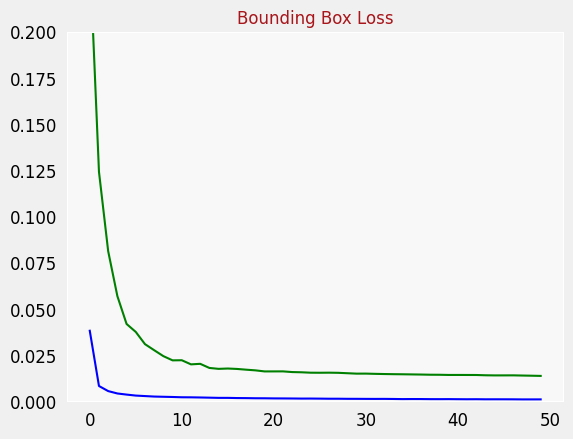

In [24]:
plot_metrics("loss", "Bounding Box Loss", ylim=0.2)

### Evaluate performance using IoU

In [25]:
def intersection_over_union(pred_box, true_box):

    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    #Calculate coordinates of overlap area between boxes
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    #Calculates area of true and predicted boxes
    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    #Calculates overlap area and union area.
    overlap_area = np.maximum((xmax_overlap - xmin_overlap),0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    # Defines a smoothing factor to prevent division by 0
    smoothing_factor = 1e-10

    #Updates iou score
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

#Makes predictions
original_images, normalized_images, normalized_bboxes = dataset_to_numpy_with_original_bboxes_util(visualization_validation_dataset, N=500)
predicted_bboxes = model.predict(normalized_images.astype('float32'))


#Calculates IOU and reports true positives and false positives based on IOU threshold
iou = intersection_over_union(predicted_bboxes, normalized_bboxes)
iou_threshold = 0.5

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step
Number of predictions where iou > threshold(0.5): 284
Number of predictions where iou < threshold(0.5): 216


## Visualize Predictions

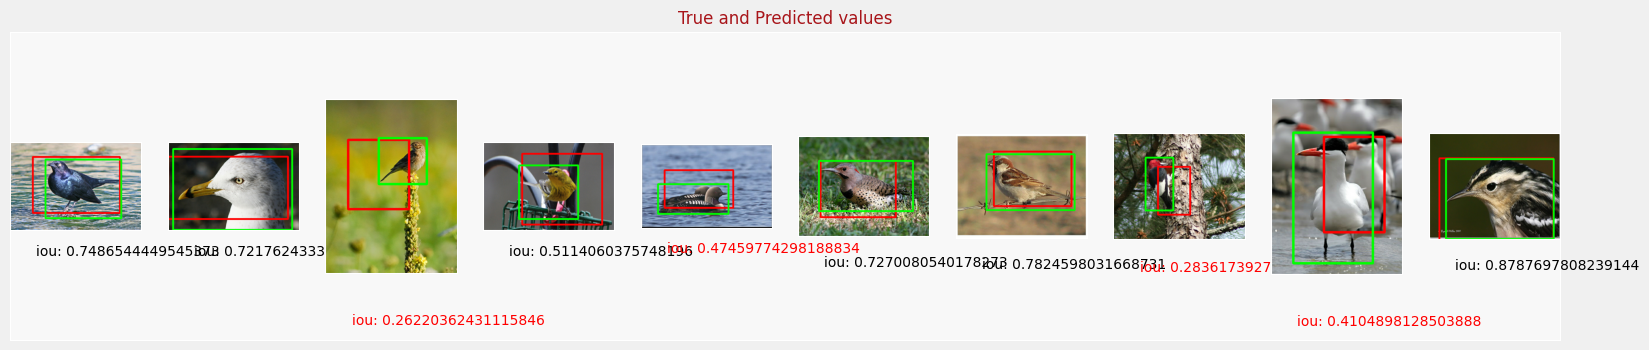

In [26]:
n = 10
indexes = np.random.choice(len(predicted_bboxes), size=n)

iou_to_draw = iou[indexes]
norm_to_draw = original_images[indexes]
display_digits_with_boxes(original_images[indexes], predicted_bboxes[indexes], normalized_bboxes[indexes], iou[indexes], "True and Predicted values", bboxes_normalized=True)

## Save the Model

In [27]:
# Save the model you just trained
model.save("temp_model.h5")